## SVM e PCA per classificazione volti

In [0]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [0]:
from time import time
import logging
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC

In [0]:
def plot_gallery(images, h, w, n_row=3, n_col=4, titles=None):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray, interpolation='bilinear')
        if titles != None:
            plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [5]:
lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

In [11]:
lfw_people.keys()

dict_keys(['data', 'images', 'target', 'target_names', 'DESCR'])

In [6]:
lfw_people.images.shape

(1288, 50, 37)

In [0]:
n_samples, h, w = lfw_people.images.shape

In [0]:
X = lfw_people.data

In [14]:
X.shape

(1288, 1850)

In [15]:
lfw_people.target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [0]:
n_features = X.shape[1]

In [0]:
t = lfw_people.target
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

In [18]:
n_classes

7

In [19]:
print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)

Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


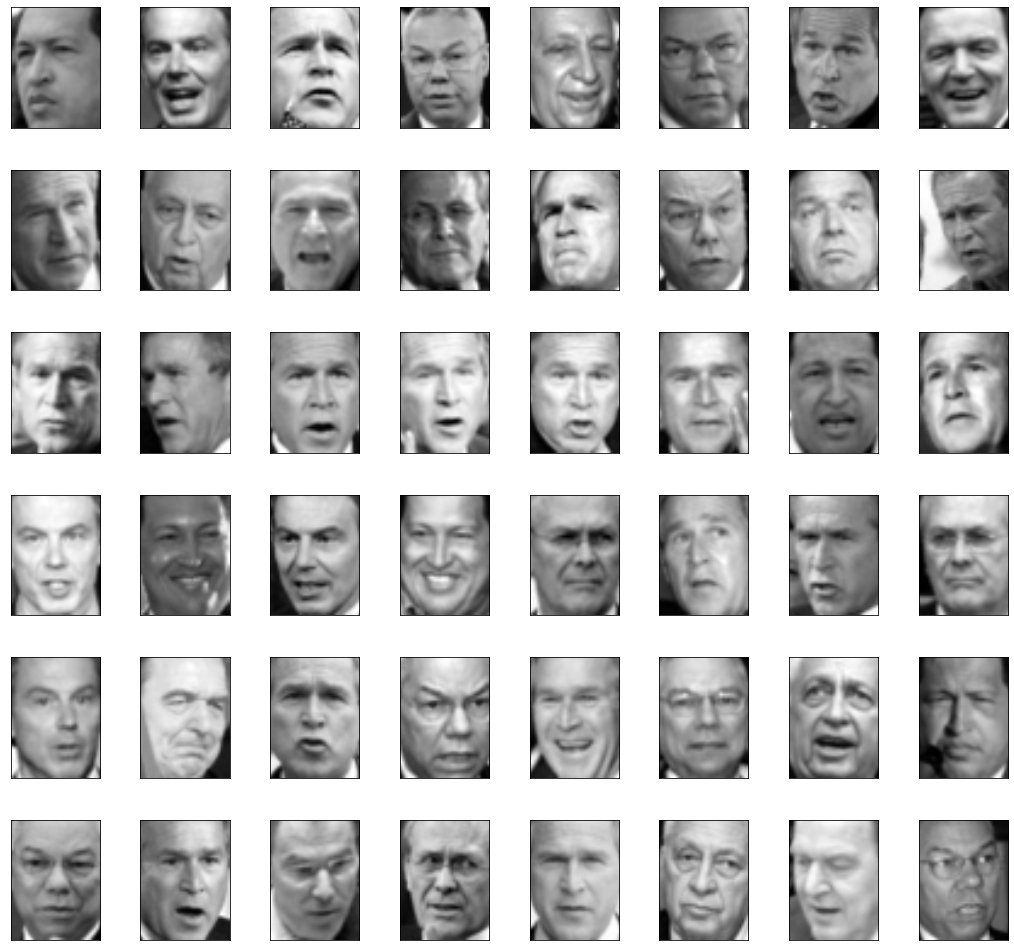

In [22]:
plot_gallery(X, h, w, n_row=6, n_col=8)

In [41]:
for i,c in enumerate(lfw_people.target_names):
  nitems = np.where(t==i)[0].shape[0]
  print('{0:s}: {1:3d} occorrenze, ({2:4.1f}%)'.format(c,nitems, nitems/n_samples*100))

Ariel Sharon:  77 occorrenze, ( 6.0%)
Colin Powell: 236 occorrenze, (18.3%)
Donald Rumsfeld: 121 occorrenze, ( 9.4%)
George W Bush: 530 occorrenze, (41.1%)
Gerhard Schroeder: 109 occorrenze, ( 8.5%)
Hugo Chavez:  71 occorrenze, ( 5.5%)
Tony Blair: 144 occorrenze, (11.2%)


In [0]:
# split into a training and testing set
X_train, X_test, t_train, t_test = train_test_split(X, t, stratify=t, test_size=0.25)

In [0]:
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [49]:
for i,c in enumerate(lfw_people.target_names):
  nitems = np.where(t_train==i)[0].shape[0]
  print('{0:s}: {1:3d} occorrenze, ({2:4.1f}%)'.format(c,nitems, nitems/n_samples*100))

Ariel Sharon:  58 occorrenze, ( 4.5%)
Colin Powell: 177 occorrenze, (13.7%)
Donald Rumsfeld:  91 occorrenze, ( 7.1%)
George W Bush: 397 occorrenze, (30.8%)
Gerhard Schroeder:  82 occorrenze, ( 6.4%)
Hugo Chavez:  53 occorrenze, ( 4.1%)
Tony Blair: 108 occorrenze, ( 8.4%)


Use PCA for dimensionality reduction

In [92]:
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 50

print("Extracting the top %d eigenfaces from %d faces" % (n_components, X_train.shape[0]))
pca = PCA(n_components=n_components, svd_solver='randomized', whiten=True).fit(X_train)

eigenfaces = pca.components_.reshape((n_components, h, w))

print("Projecting the input data on the eigenfaces orthonormal basis")
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

Extracting the top 50 eigenfaces from 966 faces
Projecting the input data on the eigenfaces orthonormal basis


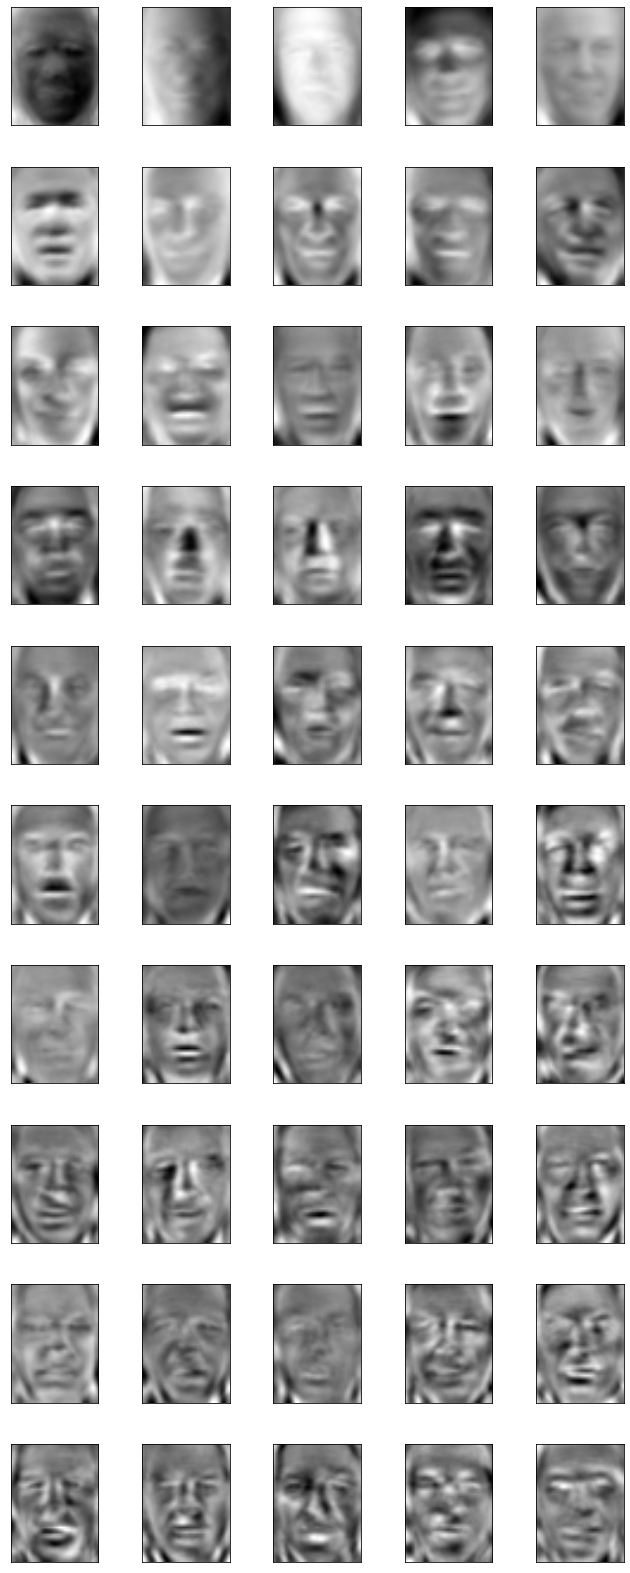

In [93]:
plot_gallery(eigenfaces, h, w, n_row=10, n_col=5)

In [0]:
# Train a SVM classification model
param_grid = {'C': [1e2, 1e3], 'gamma': [0.1, 0.2], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, t_train)

In [95]:
print("Best estimator found by grid search:")
print(clf.best_estimator_)
print(clf.best_score_)
print(clf.best_params_)

Best estimator found by grid search:
SVC(C=100.0, break_ties=False, cache_size=200, class_weight='balanced',
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma=0.1, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
0.44719833342236
{'C': 100.0, 'gamma': 0.1}


In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
p = Pipeline([('scaler', StandardScaler()), ('pca', PCA(svd_solver='randomized', whiten=True)), ('svc', SVC(kernel='rbf', class_weight='balanced'))])
param_grid = {'pca__n_components': [19, 20, 21], 'svc__C': [50, 60, 70], 'svc__gamma': [0.06, 0.07, 0.08], }
p = GridSearchCV(p, param_grid)
p = p.fit(X_train_pca, t_train)

In [87]:
print("Best estimator found by grid search:")
print(p.best_estimator_)
print(p.best_score_)
print(p.best_params_)

Best estimator found by grid search:
Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('pca',
                 PCA(copy=True, iterated_power='auto', n_components=20,
                     random_state=None, svd_solver='randomized', tol=0.0,
                     whiten=True)),
                ('svc',
                 SVC(C=50, break_ties=False, cache_size=200,
                     class_weight='balanced', coef0=0.0,
                     decision_function_shape='ovr', degree=3, gamma=0.07,
                     kernel='rbf', max_iter=-1, probability=False,
                     random_state=None, shrinking=True, tol=0.001,
                     verbose=False))],
         verbose=False)
0.7060039527803001
{'pca__n_components': 20, 'svc__C': 50, 'svc__gamma': 0.07}


In [88]:
y_pred = p.predict(X_train_pca)
print(classification_report(t_train, y_pred, target_names=target_names))
print(confusion_matrix(t_train, y_pred))

                   precision    recall  f1-score   support

     Ariel Sharon       1.00      1.00      1.00        58
     Colin Powell       1.00      1.00      1.00       177
  Donald Rumsfeld       1.00      1.00      1.00        91
    George W Bush       1.00      1.00      1.00       397
Gerhard Schroeder       1.00      1.00      1.00        82
      Hugo Chavez       1.00      1.00      1.00        53
       Tony Blair       1.00      1.00      1.00       108

         accuracy                           1.00       966
        macro avg       1.00      1.00      1.00       966
     weighted avg       1.00      1.00      1.00       966

[[ 58   0   0   0   0   0   0]
 [  0 177   0   0   0   0   0]
 [  0   0  91   0   0   0   0]
 [  0   0   0 397   0   0   0]
 [  0   0   0   0  82   0   0]
 [  0   0   0   0   0  53   0]
 [  0   0   0   0   0   0 108]]


In [89]:
print("Predicting people's names on the test set")
y_pred = p.predict(X_test_pca)

print(classification_report(t_test, y_pred, target_names=target_names))
print(confusion_matrix(t_test, y_pred, labels=range(n_classes)))

Predicting people's names on the test set
                   precision    recall  f1-score   support

     Ariel Sharon       0.89      0.42      0.57        19
     Colin Powell       0.73      0.73      0.73        59
  Donald Rumsfeld       0.72      0.60      0.65        30
    George W Bush       0.72      0.89      0.80       133
Gerhard Schroeder       0.44      0.30      0.36        27
      Hugo Chavez       0.64      0.50      0.56        18
       Tony Blair       0.55      0.47      0.51        36

         accuracy                           0.69       322
        macro avg       0.67      0.56      0.60       322
     weighted avg       0.68      0.69      0.68       322

[[  8   3   1   7   0   0   0]
 [  1  43   2   8   2   1   2]
 [  0   2  18  10   0   0   0]
 [  0   6   3 119   1   1   3]
 [  0   2   1   8   8   3   5]
 [  0   0   0   1   4   9   4]
 [  0   3   0  13   3   0  17]]


In [0]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[t_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)

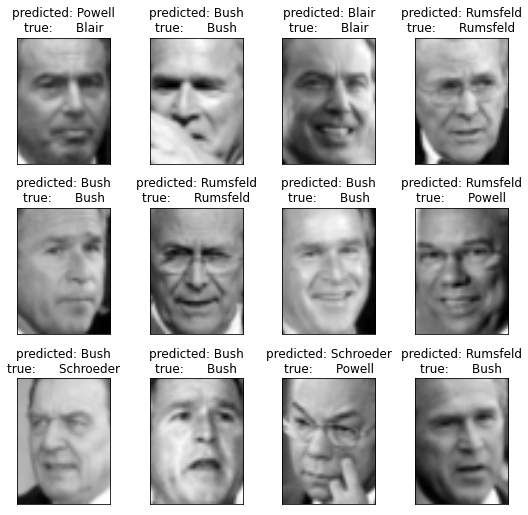

In [91]:
prediction_titles = [title(y_pred, t_test, target_names, i) for i in range(y_pred.shape[0])]

plot_gallery(X_test, h, w, titles=prediction_titles)